In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import pandas as pd

# Define the base image directory
base_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)/'

# Folder to score mapping
folder_score_map = {
    'Healthy': 10,
    'stripe_rust': 4,
    'septoria': 6
}

# Collect image paths and scores
data = []
for folder, score in folder_score_map.items():
    folder_path = os.path.join(base_dir, folder)
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            relative_path = os.path.join(folder, fname)
            data.append({'image_path': relative_path, 'score': score})

# Create dataframe
df = pd.DataFrame(data)

# Sort by filename
df = df.sort_values(by='image_path')

# Save to CSV
csv_path = '/content/drive/MyDrive/arch/leaf_scores.csv'
df.to_csv(csv_path, index=False)

print(f"CSV created with {len(df)} entries at: {csv_path}")


CSV created with 407 entries at: /content/drive/MyDrive/arch/leaf_scores.csv


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class LeafHealthScoreDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        score = torch.tensor(row['score'], dtype=torch.float32)
        return image, score


In [4]:
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

csv_path = '/content/drive/MyDrive/arch/leaf_scores.csv'
image_dir = '/content/drive/MyDrive/arch/wheat_leaf (1)'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = LeafHealthScoreDataset(csv_path, image_dir, transform=transform)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [5]:

import torch, torch.nn as nn, torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import numpy as np, time, copy, json, matplotlib.pyplot as plt
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = Path('figures'); save_dir.mkdir(exist_ok=True)


def epoch_accuracy(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

# training loop that RETURNS HISTORY for plotting
def train_model(model, train_loader, val_loader, epochs=25, lr=1e-4, wd=0.0):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

    best_w = copy.deepcopy(model.state_dict()); best_acc = 0.0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'lr':[]}

    for epoch in range(1, epochs+1):
        t0 = time.time()
        # train
        model.train(); tr_loss=0; tr_acc=0; n=0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out,y); loss.backward(); optimizer.step()
            bs = y.size(0); tr_loss += loss.item()*bs; tr_acc += epoch_accuracy(out,y)*bs; n += bs
        tr_loss /= n; tr_acc /= n

        # val
        model.eval(); va_loss=0; va_acc=0; n=0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out,y)
                bs = y.size(0); va_loss += loss.item()*bs; va_acc += epoch_accuracy(out,y)*bs; n += bs
        va_loss /= n; va_acc /= n
        scheduler.step(va_loss)

        history['train_loss'].append(tr_loss)
        history['val_loss'].append(va_loss)
        history['train_acc'].append(tr_acc)
        history['val_acc'].append(va_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        if va_acc>best_acc:
            best_acc=va_acc; best_w=copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:02d} | "
              f"loss {tr_loss:.3f}/{va_loss:.3f} | "
              f"acc {tr_acc:.3f}/{va_acc:.3f} | "
              f"lr {optimizer.param_groups[0]['lr']:.2e} | "
              f"{time.time()-t0:.1f}s")

    model.load_state_dict(best_w)
    return model, history

# create heads for 3 classes
def resnet_head(model, n_classes=3):
    in_f = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_f, n_classes)
    )
    return model

# instantiate three models
def make_resnets(n_classes=3):
    m18  = resnet_head(models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1), n_classes)
    m34  = resnet_head(models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1), n_classes)
    m50  = resnet_head(models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2), n_classes)
    return m18, m34, m50


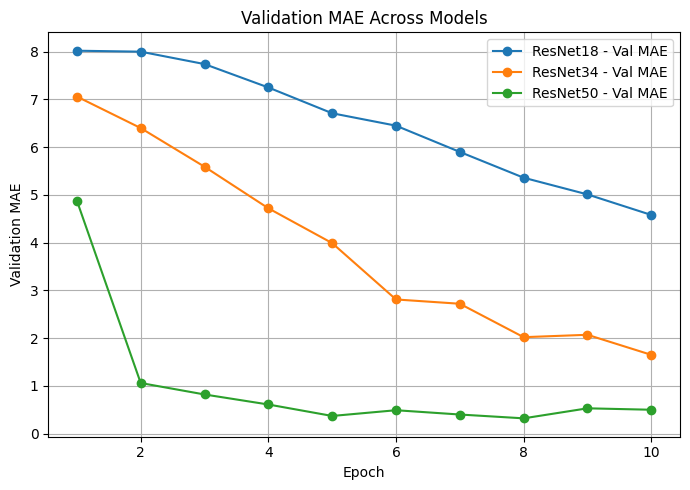

In [6]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Validation MAE values
resnet18_val_mae = [8.02, 8.00, 7.74, 7.25, 6.71, 6.45, 5.90, 5.36, 5.01, 4.58]
resnet34_val_mae = [7.06, 6.40, 5.59, 4.72, 3.99, 2.81, 2.72, 2.02, 2.07, 1.65]
resnet50_val_mae = [4.88, 1.06, 0.82, 0.61, 0.37, 0.49, 0.40, 0.32, 0.53, 0.50]

# Plot
plt.figure(figsize=(7,5))
plt.plot(epochs, resnet18_val_mae, marker='o', label="ResNet18 - Val MAE")
plt.plot(epochs, resnet34_val_mae, marker='o', label="ResNet34 - Val MAE")
plt.plot(epochs, resnet50_val_mae, marker='o', label="ResNet50 - Val MAE")

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Validation MAE")
plt.title("Validation MAE Across Models")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save and show
plt.savefig("val_mae_across_models.png", dpi=300, bbox_inches="tight")
plt.show()
